# Imports

In [13]:
import numpy as np
import pandas as pd
import keijzer_exogan as ke
import glob
import copy
import seaborn as sns
import math

import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# Getting MakeAI file paths

In [14]:
#path = '/datb/16011015/MakeAI' #datascience server
path = '/shared/datasets/16011015/MakeAI' # gpu server

trans_ = glob.glob(path+'/*/trans')
params_ = glob.glob(path+'/*/parameters')
ariels = glob.glob(path+'/*/contr_trans_ARIEL')

# Loading trans

In [15]:
trans = np.loadtxt(trans_[0])
trans.shape

(1538, 4)

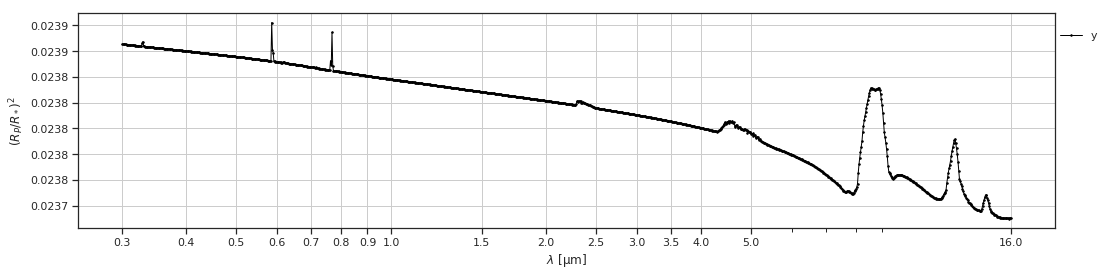

In [16]:
x = trans[:, 0]
y = trans[:, 1]


ke.plot_trans(x,y, x_max=16)

# Fix the R=200 instead of R=100 problem. 
Take the x values from MakeAI as close to the ExoGAN x points as possible

In [17]:
def match_arcis_to_exogan_lambda_values(trans):
    """
    trans: np.loadtxt() loaded trans file from ARCiS MakeAI
    output: trans converted to dataframe that match the ExoGAN wavelengths up to 16 micron.
    
    Example:
    exogan wavelengths: 0.30, 0.35. 0.40
    trans wavelengths: 0.31, 0.32, 0.35, 0.39, 0.45
    Then the output df would contain: 0.31, 0.35, 0.39
    """
    
    """prepare exogan wavelengths"""
    # load exogan wavelengths to match trans to
    df = pd.read_csv('wavelengths_and_indices.csv', header=None, skiprows=[0], usecols=[1]) # load wavelengths
    df.columns = ['x']
    df = df.loc[df['x'] <= 16] # select only wavelengths <= 16
    
    # dfe for 'df exogan'
    dfe = df.iloc[::-1] # flip rows
    dfe = dfe.reset_index(drop=True) # reset index
    
    """prepare trans"""
    x = trans[:, 0] # expected MakeAI ARCiS format
    y = trans[:, 1]
    
    # dfa for 'df ARCiS'
    dfa = pd.DataFrame([x,y]).T
    dfa.columns = ['x', 'y']
    
    """Get the lambda values that are the closest match to exogan"""
    closest_matches = []
    for target in dfe['x']:
        delta_previous = 99999
        previous_point = 99999

        for current_point in dfa['x']: # loop over all points in dfa
            delta_current = np.abs(target-current_point) # the absolute difference between the target and selected point

            if delta_current < delta_previous:
                delta_previous = delta_current
                previous_point = current_point

            else:
                closest_matches.append(previous_point)
                break
    
    dfa_selection = dfa[dfa['x'].isin(closest_matches)] # grab the values from dfa that match closest_matches
    
    return dfa_selection

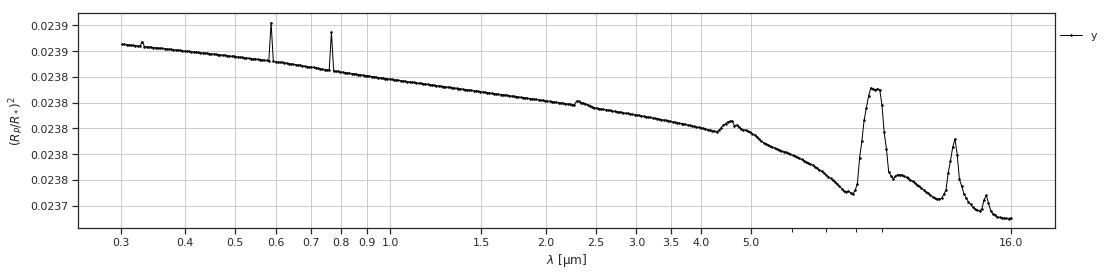

In [18]:
trans = np.loadtxt(trans_[0])
df = match_arcis_to_exogan_lambda_values(trans)

ke.plot_trans(df.x, df.y)

# Get global min max values to use for normalization

# Get params

In [19]:
def get_arcis_makeai_params(path_to_file):
    """
    Returns dict {'param':value}
    """
    params = np.genfromtxt(path_to_file, usecols=np.arange(0,3), skip_header=1, dtype='str')
    params[:,2] = params[:,2]
    params = params[:, [0,2]]
    
    params = dict(params)
    
    for key in params:
        params[key] = float(params[key])
    
    return params

In [20]:
get_arcis_makeai_params(params_[0])

{'Dplanet': 0.082722189,
 'Rp': 1.5156828,
 'Mp': 1.9874435,
 'betaT': 0.23693979,
 'TeffP': 37.474962,
 'fdry': 2.8935996,
 'fwet': 0.87848244,
 'cloud1:Sigmadot': 2.466887e-14,
 'cloud1:Kzz': 465095190.0,
 'Tform': 100.0,
 'f_dry': 2.8935996,
 'f_wet': 0.87848244,
 'COratio': 0.7791348,
 'metallicity': 0.23163745}

# Get abundances

In [21]:
def get_makeai_abundances(path_to_file):
    """
    Opens path_to_file and returns dict with abundances
    path_to_file: 'contr_trans_ARIEL' file path
    
    """
    
    
    # Open file, read raw data
    with open(path_to_file) as file:
        words = file.readlines()
        abundances = words[:17]
        
    arr = np.char.split(abundances)
    
    # Put names & values in lists
    ab_names = []
    ab_values = []
    for array in arr:
        ab_names.append(array[1])
        ab_values.append(array[-1])
    
    # Convert these lists to dict like exogan params
    abundances = np.array([ab_names, ab_values])
    
    abundances = dict.fromkeys(ab_names, 0)
    
    for i,key in enumerate(abundances.keys()):
        abundances[key] = float(ab_values[i])
        
    return abundances

In [22]:
get_makeai_abundances(ariels[0])

{'T': 1080.126,
 'P': 0.208,
 'H2O': 8.257e-07,
 'CO2': 1.242e-09,
 'CO': 0.000893,
 'CH4': 1.42e-06,
 'SO2': 1.008e-20,
 'NH3': 6.216e-08,
 'HCN': 2.794e-09,
 'C2H2': 4.857e-12,
 'C2H4': 3.323e-14,
 'H2': 0.8533,
 'He': 0.1453,
 'Na': 8.542e-06,
 'K': 5.12e-07,
 'TiO': 1.567e-10,
 'VO': 6.737e-11}

# Get min max param and abundance info for normalization

In [23]:
# get list of all param dicts

params_dicts = []
for i in range(len(ariels)): # for debugging purposes only take the first 5
    params = get_arcis_makeai_params(params_[i])
    abundances = get_makeai_abundances(ariels[i])

    # create one dict with params and abundances, calling it params 
    params = {**params, **abundances}
    
    params_dicts.append(params)

In [24]:
len(params_dicts)

2340

In [25]:
params_dicts[0] # display a dict

{'Dplanet': 0.082722189,
 'Rp': 1.5156828,
 'Mp': 1.9874435,
 'betaT': 0.23693979,
 'TeffP': 37.474962,
 'fdry': 2.8935996,
 'fwet': 0.87848244,
 'cloud1:Sigmadot': 2.466887e-14,
 'cloud1:Kzz': 465095190.0,
 'Tform': 100.0,
 'f_dry': 2.8935996,
 'f_wet': 0.87848244,
 'COratio': 0.7791348,
 'metallicity': 0.23163745,
 'T': 1080.126,
 'P': 0.208,
 'H2O': 8.257e-07,
 'CO2': 1.242e-09,
 'CO': 0.000893,
 'CH4': 1.42e-06,
 'SO2': 1.008e-20,
 'NH3': 6.216e-08,
 'HCN': 2.794e-09,
 'C2H2': 4.857e-12,
 'C2H4': 3.323e-14,
 'H2': 0.8533,
 'He': 0.1453,
 'Na': 8.542e-06,
 'K': 5.12e-07,
 'TiO': 1.567e-10,
 'VO': 6.737e-11}

In [26]:
dfs = [pd.DataFrame(params_dict, index=[0]) for params_dict in tqdm(params_dicts)]
df = pd.concat(dfs)
df = df.reset_index(drop=True)

100%|██████████| 2340/2340 [00:03<00:00, 635.90it/s]


In [27]:
df.head()

,Dplanet,Rp,Mp,betaT,TeffP,fdry,fwet,cloud1:Sigmadot,cloud1:Kzz,Tform,...,NH3,HCN,C2H2,C2H4,H2,He,Na,K,TiO,VO
0,0.082722,1.515683,1.987443,0.236940,37.474962,2.893600,0.878482,2.466887e-14,465095190.0,100.0,...,6.216000e-08,2.794000e-09,4.857000e-12,3.323000e-14,0.8533,0.1453,8.542000e-06,5.120000e-07,1.567000e-10,6.737000e-11
1,0.198694,2.944852,5.465739,0.178809,18.425333,1.739075,0.112151,1.298586e-14,3274651.2,100.0,...,6.003000e-06,1.370000e-17,2.150000e-26,2.931000e-18,0.8532,0.1456,1.587000e-07,5.897000e-09,1.065000e-13,3.566000e-15
2,0.140629,2.932953,3.598406,0.177857,13.943228,2.204990,0.390039,7.665524e-12,18277590.0,100.0,...,6.989000e-07,2.911000e-11,5.062000e-15,2.774000e-13,0.8536,0.1454,6.354000e-06,3.036000e-07,1.285000e-12,4.933000e-13
3,0.013438,0.647085,9.521129,0.247691,169.928130,7.103283,1.949250,7.120033e-16,2660653.1,100.0,...,1.388000e-06,1.747000e-06,3.113000e-07,2.708000e-08,0.8391,0.1440,2.034000e-05,1.239000e-06,2.135000e-08,6.987000e-10
4,0.013252,2.105214,7.924207,0.139430,34.109023,2.754793,0.172777,4.905372e-14,36478814.0,100.0,...,4.096000e-08,6.336000e-08,1.030000e-09,4.637000e-12,0.8277,0.1433,7.990000e-06,2.818000e-07,1.151000e-08,7.894000e-11


# Plot hists of original data

In [28]:
df.columns

Index(['Dplanet', 'Rp', 'Mp', 'betaT', 'TeffP', 'fdry', 'fwet',
       'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio',
       'metallicity', 'T', 'P', 'H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN',
       'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'],
      dtype='object')

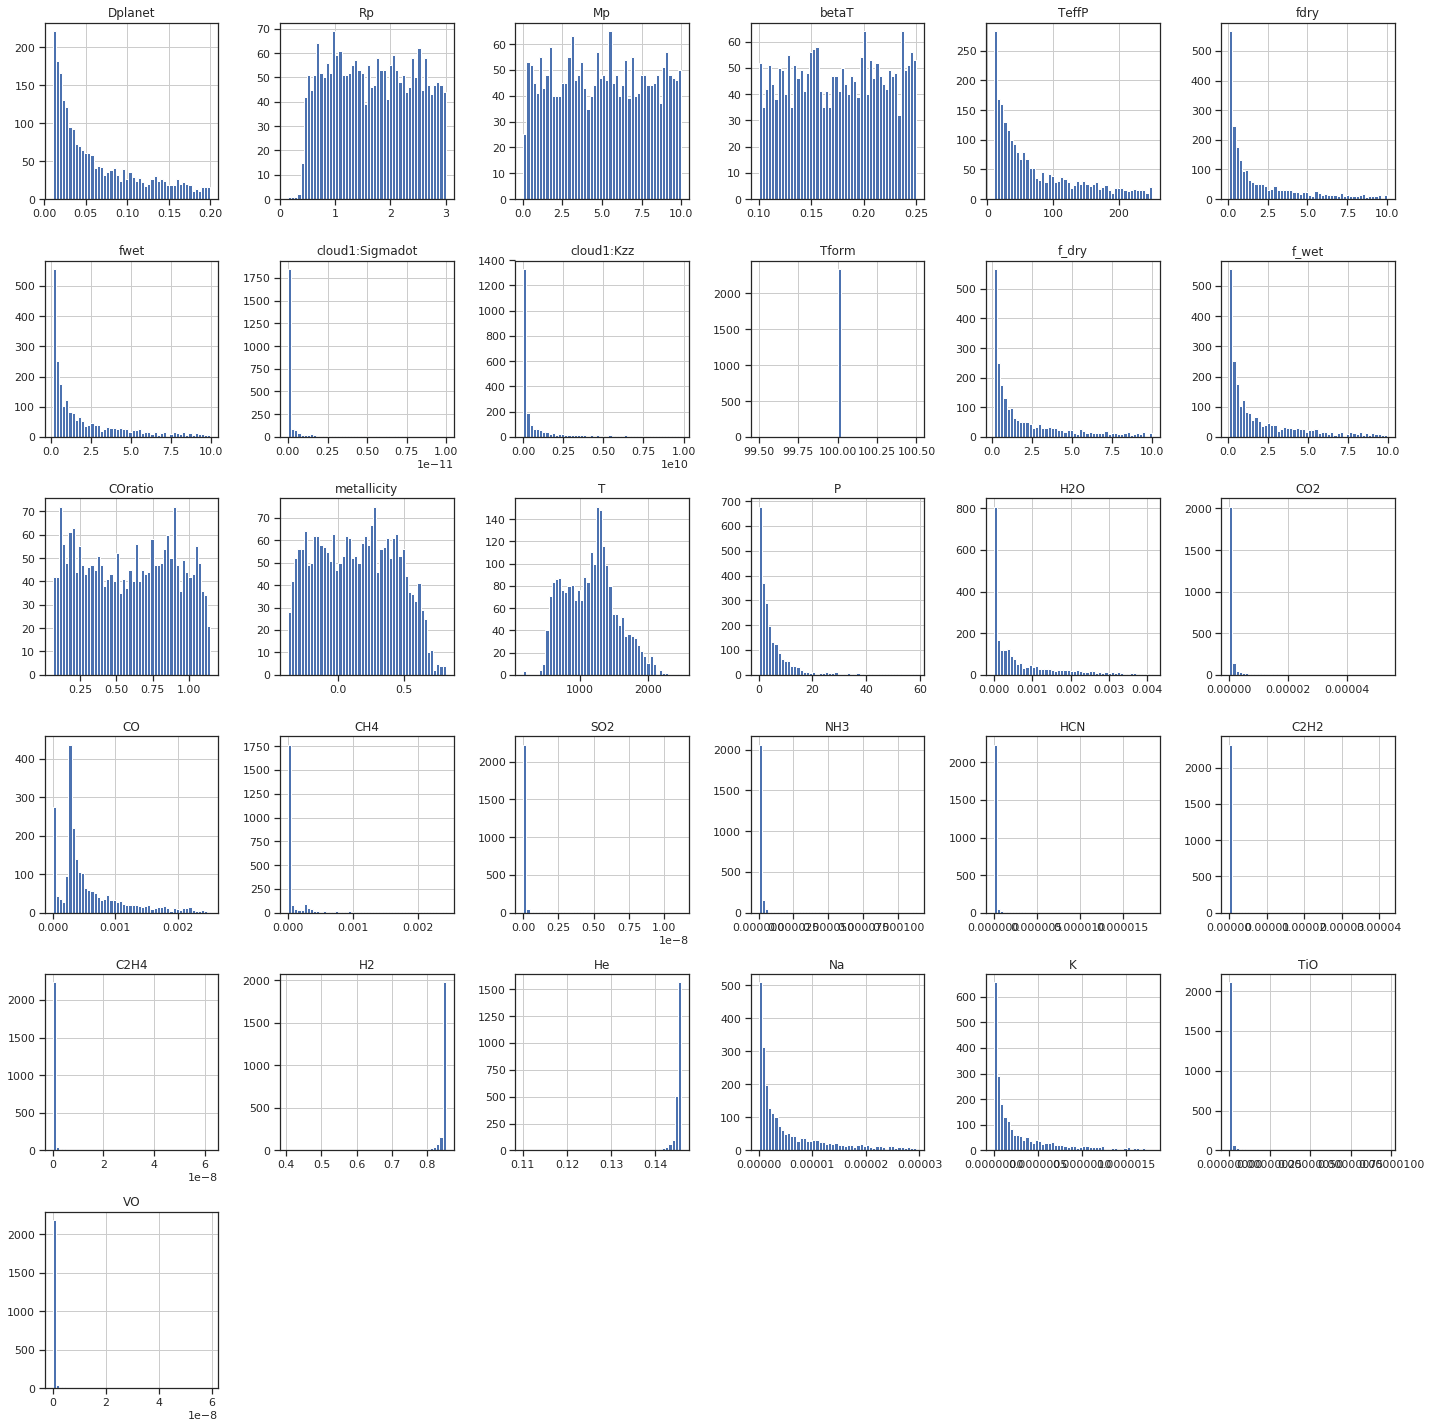

In [29]:
plt.figure(figsize=(20,20))
for i in range(len(df.columns)):
    plt.subplot(6,6,i+1)
    plt.title(df.columns[i])
    plt.hist(df.iloc[:,i], bins=50)
    plt.grid()
 
plt.tight_layout()

# Convert logarithmic sampled parameters to log scale

‘Dplanet’: afstand van de planeet tot de ster in AU (log10)  
‘Rp’: Straal van de planeet in Rjup (lineair)  
‘Mp’: Massa van de planeet in Mjup (lineair)  
‘betaT’: efficienty van instraling (lineair)    
‘TeffP’: interne temperatuur in K (log10)  
‘fdry’: accretie van sollid materiaal in de atmosfeer (log10)  
‘fwet’: accretie van waterijs (log10)  
'cloud1:Sigmadot’: nucleation rate voor de wolken (log10)  
'cloud1:Kzz’: mixing efficiency voor de wolkvorming (log10)  
‘Tform’: vormingstemperatuur (nu altijd op 100K)  
‘f_dry’: zelfde als boven  
‘f_wet’: zelfde als boven  
‘COratio’: verhouding tussen C en O in de atmosfeer; afgeleid van f_dry en f_wet  
‘metallicity’: fractie zware elementen; afgeleid van f_dry en f_wet  
’T’: temperatuur op de hoogte in de atmosfeer die het meest bijdraagt aan het spectrum  
‘P’: druk op deze hoogte in de atmosfeer  
'H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN’, 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', ‘VO’: abundanties van de moleculen op deze hoogte in de atmosfeer  

# TODO : 

Check which params are logarithmic sampled. 
Are they log10 or log (natural)?

In [30]:
df.columns

Index(['Dplanet', 'Rp', 'Mp', 'betaT', 'TeffP', 'fdry', 'fwet',
       'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio',
       'metallicity', 'T', 'P', 'H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN',
       'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'],
      dtype='object')

In [31]:
# TO DO 

to_log10 = ['H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO']
to_log = ['Dplanet', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'f_dry', 'f_wet', 'P', ]

df[to_log10] = np.log10(df[to_log10])
df[to_log] = np.log10(df[to_log])

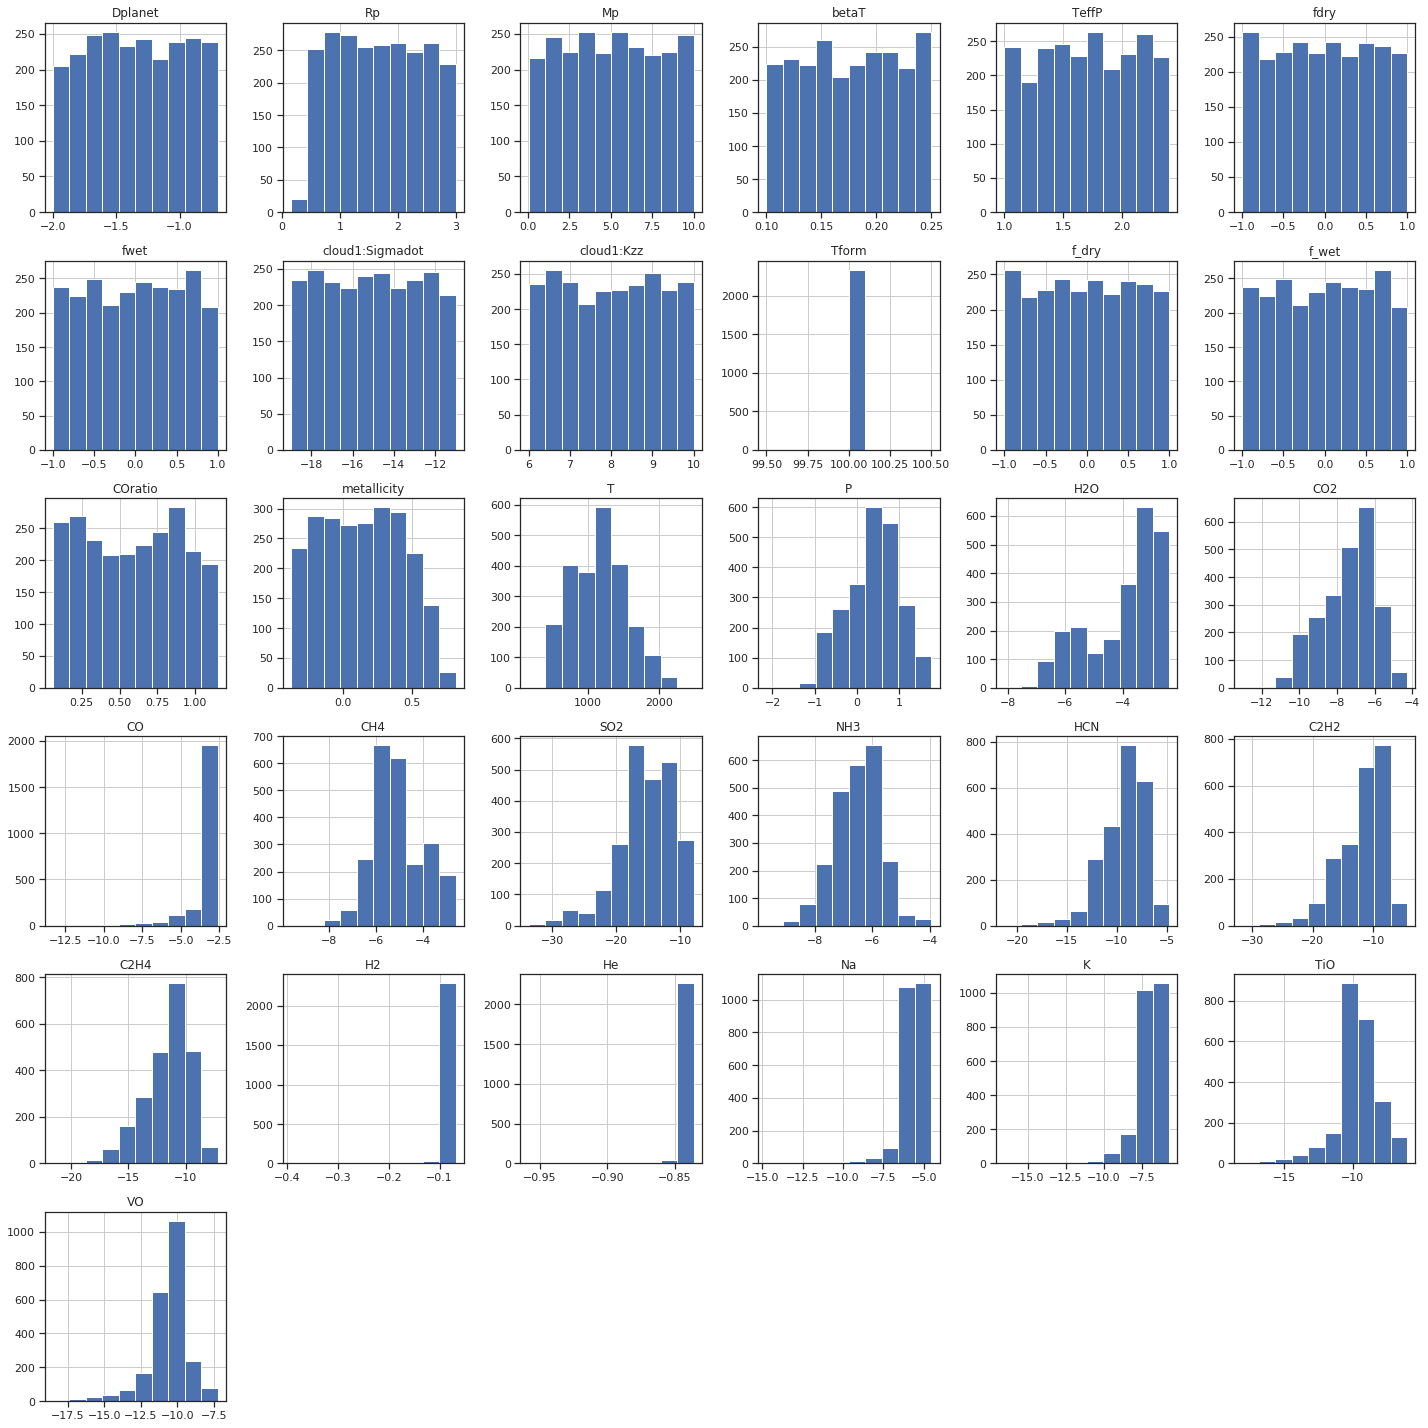

In [32]:
plt.figure(figsize=(20,20))

for i in range(len(df.columns)):
    plt.subplot(6,6,i+1)
    plt.title(df.columns[i])
    plt.hist(df.iloc[:,i], bins=10)
    plt.grid()
    
plt.tight_layout()

In [33]:
params_dict = df.to_dict('list') # convert df to dict

In [34]:
del params_dict['Tform'] # delete this because it's only one value...

In [35]:
# convert lists to np arrays
for key in params_dict.keys():
    params_dict[key] = np.array(params_dict[key])

# Split ARCiS only from ExoGAN params
Just so it's easier to fill the top and bottom of the ASPA seperately.

ExoGAN:  

    'planet_mass': [],
    'temp_profile': [],
    'ch4_mixratio': [],
    'planet_radius': [],
    'h2o_mixratio': [],
    'co2_mixratio': [],
    'co_mixratio': []

In [36]:
keys = list(params_dict.keys())

In [37]:
exo_param_names = ['Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO']

exo = {key: params_dict[key] for key in exo_param_names} # create dict with exo params

In [38]:
# create arcis params dict

arcis = copy.deepcopy(params_dict)

for key in exo_param_names: # remove exo params so only arcis params are left
    del arcis[key]

# Exo mins and maxs

In [39]:
# grab min max values per key
mins_exo = np.array([min(exo[key]) for key in exo.keys()])
maxs_exo = np.array([max(exo[key]) for key in exo.keys()])

exo.keys()

dict_keys(['Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO'])

In [40]:
mins_exo

array([ 4.25670430e-02,  1.62714000e+02, -9.60119227e+00,  1.49908510e-01,
       -8.11373494e+00, -1.30411495e+01, -1.32936236e+01])

In [41]:
maxs_exo

array([ 9.99723090e+00,  2.48117900e+03, -2.61582586e+00,  2.99875190e+00,
       -2.38531366e+00, -4.26962153e+00, -2.59980751e+00])

# ARCiS mins and maxs

In [42]:
# grab min max values per key
mins_arcis = np.array([min(arcis[key]) for key in arcis.keys()])
maxs_arcis = np.array([max(arcis[key]) for key in arcis.keys()])

arcis.keys()

dict_keys(['Dplanet', 'betaT', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'f_dry', 'f_wet', 'COratio', 'metallicity', 'P', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'])

In [43]:
mins_arcis

array([ -1.99982975,   0.1000388 ,   1.00126179,  -0.99978456,
        -0.99937355, -18.99565657,   6.00145523,  -0.99978456,
        -0.99937355,   0.05947539,  -0.37582021,  -2.14218522,
       -33.71421773,  -9.68739956, -21.28433086, -31.69229008,
       -21.57430279,  -0.39308147,  -0.95821268, -14.73306309,
       -16.52432881, -18.10646016, -18.50182734])

In [44]:
maxs_arcis

array([ -0.69903435,   0.2499561 ,   2.39778685,   0.99962839,
         0.99885968, -11.00131038,   9.99344688,   0.99962839,
         0.99885968,   1.1501613 ,   0.81627806,   1.76797172,
        -7.95078198,  -3.9465374 ,  -4.73565449,  -4.37582107,
        -7.20558167,  -0.06844043,  -0.83624248,  -4.53106219,
        -5.74617756,  -6.01139646,  -7.22628667])

# Exo: Test transform each parameter

## Exo: Hist, original

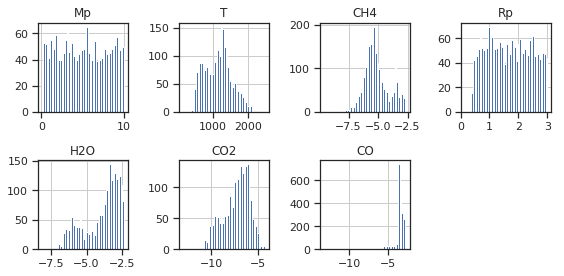

In [45]:
plt.figure(figsize=(8,4))

for i,key in enumerate(exo.keys()):
    plt.subplot(2,4,i+1)
    plt.title(key)
    plt.hist(exo[key], bins=50)
    plt.grid()
    
plt.tight_layout()

In [46]:
"""
exo params

in order: 'Dplanet', 'betaT', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio', 'metallicity', 'P', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'
"""

mins = [0.042567043,
 162.714,
 -9.601192269796735,
 0.14990851,
 -8.113734940970243,
 -13.041149548320321,
 -13.29362364416031]

maxs = [9.9972309,
 2481.179,
 -2.6158258611929663,
 2.9987519,
 -2.3853136577179876,
 -4.269621531412357,
 -2.599807511407424]

for i,key in enumerate(exo):
    exo[key] = ke.scale_param(exo[key], mins[i], maxs[i])

## Exo: Hist, transformed

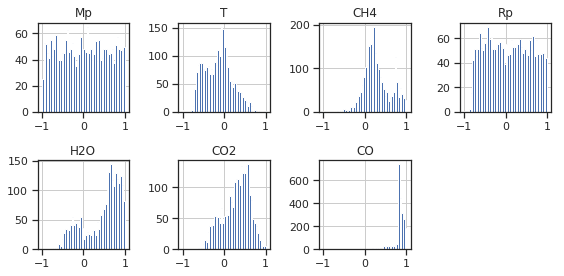

In [47]:
plt.figure(figsize=(8,4))

for i,key in enumerate(exo.keys()):
    plt.subplot(2,4,i+1)
    plt.title(key)
    plt.hist(exo[key], bins=50)
    plt.grid()
    
plt.tight_layout()

# ARCiS: Test transform each parameter

## ARCiS: Hist, original

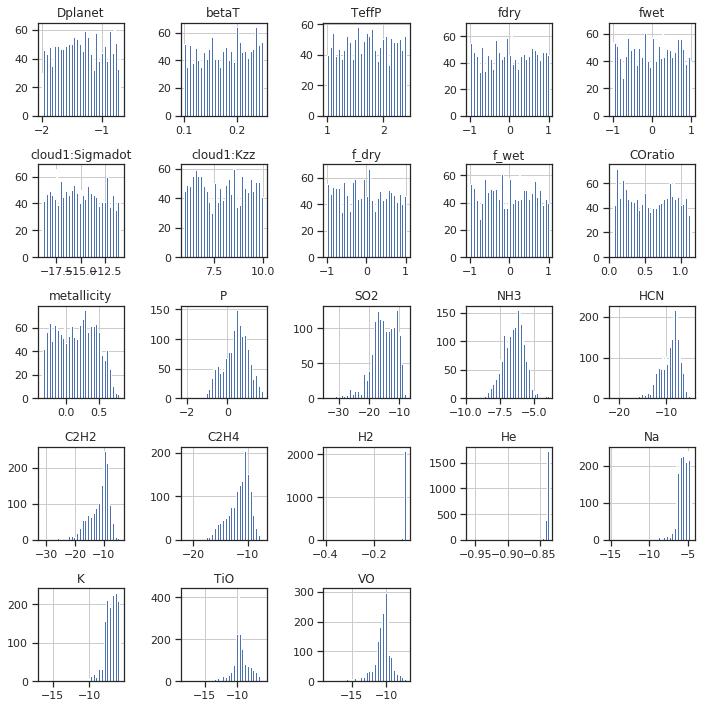

In [48]:
plt.figure(figsize=(10,10))

for i,key in enumerate(arcis.keys()):
    plt.subplot(5,5,i+1)
    plt.title(key)
    plt.hist(arcis[key], bins=50)
    plt.grid()
    
plt.tight_layout()

In [49]:
"""
arcis params

in order: 'Dplanet', 'betaT', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio', 'metallicity', 'P', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'
"""

mins = np.array([-1.99982975,   0.1000388 ,   1.00126179,  -0.99978456,
        -0.99937355, -18.99565657,   6.00145523,  -0.99978456,
        -0.99937355,   0.05947539,  -0.37582021,  -2.14218522,
       -33.71421773,  -9.68739956, -21.28433086, -31.69229008,
       -21.57430279,  -0.39308147,  -0.95821268, -14.73306309,
       -16.52432881, -18.10646016, -18.50182734])

maxs = np.array([-0.69903435,   0.2499561 ,   2.39778685,   0.99962839,
         0.99885968, -11.00131038,   9.99344688,   0.99962839,
         0.99885968,   1.1501613 ,   0.81627806,   1.76797172,
        -7.95078198,  -3.9465374 ,  -4.73565449,  -4.37582107,
        -7.20558167,  -0.06844043,  -0.83624248,  -4.53106219,
        -5.74617756,  -6.01139646,  -7.22628667])

for i,key in enumerate(arcis):
    arcis[key] = ke.scale_param(arcis[key], mins[i], maxs[i])

## ARCiS: Hist, transformed

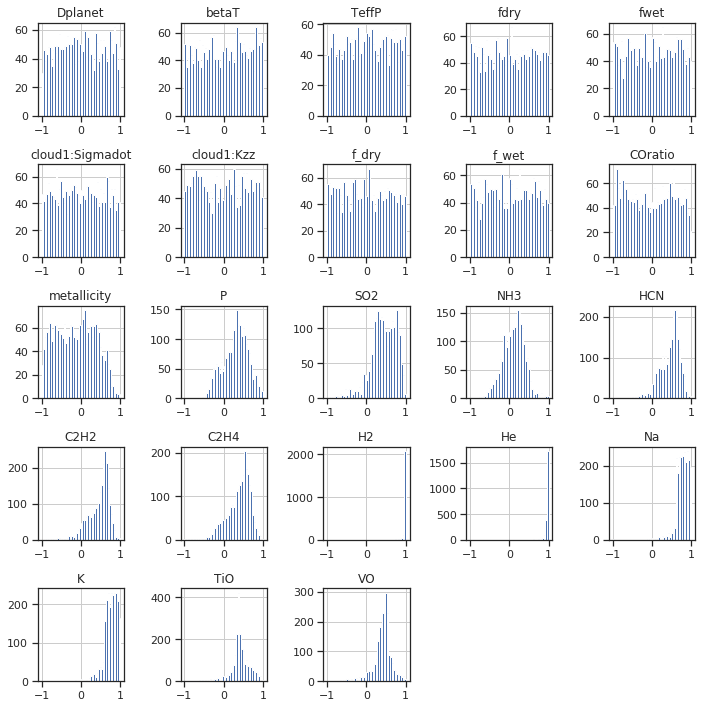

In [50]:
plt.figure(figsize=(10,10))

for i,key in enumerate(arcis.keys()):
    plt.subplot(5,5,i+1)
    plt.title(key)
    plt.hist(arcis[key], bins=50)
    plt.grid()
    
plt.tight_layout()

# MakeAI ARCiS ASPA
To inverse scale ASPA the x values would have to be known (or save a fixed wnw grid for arcis).

In [51]:
"""function inputs"""
i = 0
trans_file = trans_[i] # paths to files
params_file = params_[i]
ariels_file = ariels[i]






"""Get spectrum"""
trans = np.loadtxt(trans_file)
data = match_arcis_to_exogan_lambda_values(trans) # contains df.x and df.y (lambda and R/R)

"""Get params"""
params = get_arcis_makeai_params(params_file)
abundances = get_makeai_abundances(ariels_file)

params = {**params, **abundances} # create one dict from params and abundances dicts, calling it params 

del params['Tform'] # delete this because it's only one value...

"""Transform certain parameters from linear to log10 scale"""
# TO DO: Find out form Michiel what's been sampled in which way

to_log10 = ['H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO']
to_log = ['Dplanet', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'f_dry', 'f_wet', 'P', ]

# convert scales
for key in to_log10:
    params[key] = np.log10(params[key])
    
for key in to_log:
    params[key] = np.log(params[key])
    
# make sure everything is a ndarray
for key in params.keys():
    params[key] = np.array(params[key])

"""seperate dict into exo dict and arcis dict"""
exo_param_names = ['Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO']

exo = {key: params[key] for key in exo_param_names} # create dict with exo params

# create arcis params dict
arcis = copy.deepcopy(params)

for key in exo_param_names: # remove exo params so only arcis params are left
    del arcis[key]
    
    
"""normalization"""

"""
exo params

in order: ''Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO'
"""

mins = [0.042567043,
 162.714,
 -9.601192269796735,
 0.14990851,
 -8.113734940970243,
 -13.041149548320321,
 -13.29362364416031]

maxs = [9.9972309,
 2481.179,
 -2.6158258611929663,
 2.9987519,
 -2.3853136577179876,
 -4.269621531412357,
 -2.599807511407424]

for i,key in enumerate(exo):
    exo[key] = ke.scale_param(exo[key], mins[i], maxs[i])
    
"""
arcis params

in order: 'Dplanet', 'betaT', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio', 'metallicity', 'P', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'
"""

mins = np.array([-1.99982975,   0.1000388 ,   1.00126179,  -0.99978456,
        -0.99937355, -18.99565657,   6.00145523,  -0.99978456,
        -0.99937355,   0.05947539,  -0.37582021,  -2.14218522,
       -33.71421773,  -9.68739956, -21.28433086, -31.69229008,
       -21.57430279,  -0.39308147,  -0.95821268, -14.73306309,
       -16.52432881, -18.10646016, -18.50182734])

maxs = np.array([-0.69903435,   0.2499561 ,   2.39778685,   0.99962839,
         0.99885968, -11.00131038,   9.99344688,   0.99962839,
         0.99885968,   1.1501613 ,   0.81627806,   1.76797172,
        -7.95078198,  -3.9465374 ,  -4.73565449,  -4.37582107,
        -7.20558167,  -0.06844043,  -0.83624248,  -4.53106219,
        -5.74617756,  -6.01139646,  -7.22628667])

for i,key in enumerate(arcis):
    arcis[key] = ke.scale_param(arcis[key], mins[i], maxs[i])
    
""" Select spectrum bins """
# Could loop this, but right now this is more visual
# H2O bins
bin1 = data[data.x <= 0.44]
bin2 = data[(data.x > 0.44) & (data.x <= 0.495)]
bin3 = data[(data.x > 0.495) & (data.x <= 0.535)]
bin4 = data[(data.x > 0.535) & (data.x <= 0.58)]
bin5 = data[(data.x > 0.58) & (data.x <= 0.635)]
bin6 = data[(data.x > 0.635) & (data.x <= 0.71)]
bin7 = data[(data.x > 0.71) & (data.x <= 0.79)]
bin8 = data[(data.x > 0.79) & (data.x <= 0.9)]
bin9 = data[(data.x > 0.9) & (data.x <= 1.08)]
bin10 = data[(data.x > 1.08) & (data.x <= 1.3)]
bin11 = data[(data.x > 1.3) & (data.x <= 1.7)]
bin12 = data[(data.x > 1.7) & (data.x <= 2.35)]

# Manually chosen bins
bin13 = data[(data.x > 2.35) & (data.x <= 4)]
bin14 = data[(data.x > 4) & (data.x <= 6)]
bin15 = data[(data.x > 6) & (data.x <= 10)]
bin16 = data[(data.x > 10) & (data.x <= 14)]
bin17 = data[data.x > 14]

bins = [bin17, bin16, bin15, bin14, bin13, bin12, bin11, bin10, bin9, bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]

"""
Normalize bins
"""
scalers = [MinMaxScaler(feature_range=(-1,1)).fit(b) for b in bins] # list of ... scalers for the ... bins
mins = [ b.iloc[:,1].min() for b in bins] # .iloc[:,1] selects all rows from column 1 (which is R/R)
maxs = [ b.iloc[:,1].max() for b in bins]

bins_scaled = []
for i,b in enumerate(bins):
    bins_scaled.append(scalers[i].transform(b))

spectrum_scaled = np.concatenate(bins_scaled, axis=0)
spectrum_scaled = spectrum_scaled[:,1]

"""Spectrum"""
aspa = np.zeros((32,32))

row_length = 25 # amount of pixels used per row
n_rows = math.ceil(len(spectrum_scaled) / row_length) # amount of rows the spectrum needs in the aspa, so for 415 data points, 415/32=12.96 -> 13 rows
#print('Using %s rows' % n_rows)

for i in range(n_rows): # for i in 
    start = i*row_length
    stop = start+row_length
    spec = spectrum_scaled[start:stop]

    if len(spec) != row_length:
        n_missing_points = row_length-len(spec)
        spec = np.append(spec, [0 for _ in range(n_missing_points)]) # for last row, if length != 32, fill remaining with 0's
        #print('Filled row with %s points' % n_missing_points)

    aspa[i, :row_length] = spec
    
"""exo params"""
for i,key in enumerate(exo_param_names): # !!!!!! Need to grab the keys list which is in order, python <3.7 reorders the created dict
    aspa[:16, 25+i:26+i] = exo[key]
    
"""min max values for spectrum bins"""
for i in range(len(mins)):
    min_ = ke.scale_param(mins[i], 0.00024601534 , 0.1710588)
    max_ = ke.scale_param(maxs[i], 0.00024601534 , 0.1710588)

    aspa[16:17, i*2:i*2+2] = min_
    aspa[17:18, i*2:i*2+2] = max_

    
    
    
    
    
#"""Fill unused space with noice"""
#for i in range(14):
#    noise = np.random.rand(32) # random noise betweem 0 and 1 for each row
#    aspa[18+i:19+i*1, :] = noise
 
for i,key in enumerate(arcis.keys()):
    value = arcis[key]
    aspa[18:, i:i+1] = value
    
"""Fill unused space with some params, just so there is structure to the unused space"""
for i,key in enumerate(arcis.keys()):
    value = arcis[key]
    aspa[18+i:19+i, 23:] = value


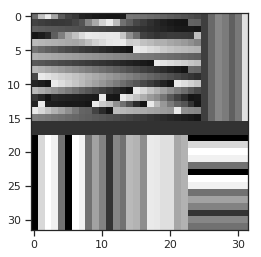

In [52]:
plt.imshow(aspa, cmap='gray', vmin=-1.2, vmax=1.2)

# Functionize ASPA creation

In [53]:
def ASPA_complex_v1(trans_file, params_file, ariels_file):
    """
    trans_file, params_file, ariels_file: file paths to respective arcis makeai files
    
    output: ndarray shape(32,32)
    """
    
    """Get spectrum"""
    trans = np.loadtxt(trans_file)
    data = match_arcis_to_exogan_lambda_values(trans) # contains df.x and df.y (lambda and R/R)

    """Get params"""
    params = get_arcis_makeai_params(params_file)
    abundances = get_makeai_abundances(ariels_file)

    params = {**params, **abundances} # create one dict from params and abundances dicts, calling it params 

    del params['Tform'] # delete this because it's only one value...

    """Transform certain parameters from linear to log10 scale"""
    # TO DO: Find out form Michiel what's been sampled in which way

    to_log10 = ['H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO']
    to_log = ['Dplanet', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'f_dry', 'f_wet', 'P', ]

    # convert scales
    for key in to_log10:
        params[key] = np.log10(params[key])

    for key in to_log:
        params[key] = np.log(params[key])

    # make sure everything is a ndarray
    for key in params.keys():
        params[key] = np.array(params[key])

    """seperate dict into exo dict and arcis dict"""
    exo_param_names = ['Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO']

    exo = {key: params[key] for key in exo_param_names} # create dict with exo params

    # create arcis params dict
    arcis = copy.deepcopy(params)

    for key in exo_param_names: # remove exo params so only arcis params are left
        del arcis[key]


    """normalization"""

    """
    exo params

    in order: ''Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO'
    """

    mins = [0.042567043,
     162.714,
     -9.601192269796735,
     0.14990851,
     -8.113734940970243,
     -13.041149548320321,
     -13.29362364416031]

    maxs = [9.9972309,
     2481.179,
     -2.6158258611929663,
     2.9987519,
     -2.3853136577179876,
     -4.269621531412357,
     -2.599807511407424]

    for i,key in enumerate(exo):
        exo[key] = ke.scale_param(exo[key], mins[i], maxs[i])

    """
    arcis params

    in order: 'Dplanet', 'betaT', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio', 'metallicity', 'P', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'
    """

    mins = np.array([-1.99982975,   0.1000388 ,   1.00126179,  -0.99978456,
            -0.99937355, -18.99565657,   6.00145523,  -0.99978456,
            -0.99937355,   0.05947539,  -0.37582021,  -2.14218522,
           -33.71421773,  -9.68739956, -21.28433086, -31.69229008,
           -21.57430279,  -0.39308147,  -0.95821268, -14.73306309,
           -16.52432881, -18.10646016, -18.50182734])

    maxs = np.array([-0.69903435,   0.2499561 ,   2.39778685,   0.99962839,
             0.99885968, -11.00131038,   9.99344688,   0.99962839,
             0.99885968,   1.1501613 ,   0.81627806,   1.76797172,
            -7.95078198,  -3.9465374 ,  -4.73565449,  -4.37582107,
            -7.20558167,  -0.06844043,  -0.83624248,  -4.53106219,
            -5.74617756,  -6.01139646,  -7.22628667])

    for i,key in enumerate(arcis):
        arcis[key] = ke.scale_param(arcis[key], mins[i], maxs[i])

    """ Select spectrum bins """
    # Could loop this, but right now this is more visual
    # H2O bins
    bin1 = data[data.x <= 0.44]
    bin2 = data[(data.x > 0.44) & (data.x <= 0.495)]
    bin3 = data[(data.x > 0.495) & (data.x <= 0.535)]
    bin4 = data[(data.x > 0.535) & (data.x <= 0.58)]
    bin5 = data[(data.x > 0.58) & (data.x <= 0.635)]
    bin6 = data[(data.x > 0.635) & (data.x <= 0.71)]
    bin7 = data[(data.x > 0.71) & (data.x <= 0.79)]
    bin8 = data[(data.x > 0.79) & (data.x <= 0.9)]
    bin9 = data[(data.x > 0.9) & (data.x <= 1.08)]
    bin10 = data[(data.x > 1.08) & (data.x <= 1.3)]
    bin11 = data[(data.x > 1.3) & (data.x <= 1.7)]
    bin12 = data[(data.x > 1.7) & (data.x <= 2.35)]

    # Manually chosen bins
    bin13 = data[(data.x > 2.35) & (data.x <= 4)]
    bin14 = data[(data.x > 4) & (data.x <= 6)]
    bin15 = data[(data.x > 6) & (data.x <= 10)]
    bin16 = data[(data.x > 10) & (data.x <= 14)]
    bin17 = data[data.x > 14]

    bins = [bin17, bin16, bin15, bin14, bin13, bin12, bin11, bin10, bin9, bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]

    """
    Normalize bins
    """
    scalers = [MinMaxScaler(feature_range=(-1,1)).fit(b) for b in bins] # list of ... scalers for the ... bins
    mins = [ b.iloc[:,1].min() for b in bins] # .iloc[:,1] selects all rows from column 1 (which is R/R)
    maxs = [ b.iloc[:,1].max() for b in bins]

    bins_scaled = []
    for i,b in enumerate(bins):
        bins_scaled.append(scalers[i].transform(b))

    spectrum_scaled = np.concatenate(bins_scaled, axis=0)
    spectrum_scaled = spectrum_scaled[:,1]

    """Spectrum"""
    aspa = np.zeros((32,32))

    row_length = 25 # amount of pixels used per row
    n_rows = math.ceil(len(spectrum_scaled) / row_length) # amount of rows the spectrum needs in the aspa, so for 415 data points, 415/32=12.96 -> 13 rows
    #print('Using %s rows' % n_rows)

    for i in range(n_rows): # for i in 
        start = i*row_length
        stop = start+row_length
        spec = spectrum_scaled[start:stop]

        if len(spec) != row_length:
            n_missing_points = row_length-len(spec)
            spec = np.append(spec, [0 for _ in range(n_missing_points)]) # for last row, if length != 32, fill remaining with 0's
            #print('Filled row with %s points' % n_missing_points)

        aspa[i, :row_length] = spec

    """exo params"""
    for i,key in enumerate(exo_param_names): # !!!!!! Need to grab the keys list which is in order, python <3.7 reorders the created dict
        aspa[:16, 25+i:26+i] = exo[key]

    """min max values for spectrum bins"""
    for i in range(len(mins)):
        min_ = ke.scale_param(mins[i], 0.00024601534 , 0.1710588)
        max_ = ke.scale_param(maxs[i], 0.00024601534 , 0.1710588)

        aspa[16:17, i*2:i*2+2] = min_
        aspa[17:18, i*2:i*2+2] = max_






    #"""Fill unused space with noice"""
    #for i in range(14):
    #    noise = np.random.rand(32) # random noise betweem 0 and 1 for each row
    #    aspa[18+i:19+i*1, :] = noise

    for i,key in enumerate(arcis.keys()):
        value = arcis[key]
        aspa[18:, i:i+1] = value

    """Fill unused space with some params, just so there is structure to the unused space"""
    for i,key in enumerate(arcis.keys()):
        value = arcis[key]
        aspa[18+i:19+i, 23:] = value
    
    return aspa

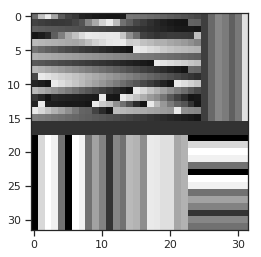

In [54]:
# try out

i = 0
trans_file = trans_[i] # paths to files
params_file = params_[i]
ariels_file = ariels[i]

aspa = ASPA_complex_v1(trans_file, params_file, ariels_file)

plt.imshow(aspa, cmap='gray', vmin=-1.2, vmax=1.2)